## **모델 5개 비교 후, 최적 모델 고르기**
 - features : dx, dy, dz, distance, x_angle, y_angle

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info.csv')

# 🔧 피처 엔지니어링
df['dx'] = df['x_target'] - df['x_pos']
df['dy'] = df['y_target'] - df['y_pos']
df['dz'] = df['z_target'] - df['z_pos']
df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)

# 입력(X), 출력(y)
X = df[['dx', 'dy', 'dz', 'distance']]
y = df[['x_angle', 'y_angle']]
display(df.head())

# 🔄 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ⚖️ 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

,x_pos,y_pos,z_pos,x_angle,y_angle,x_target,y_target,z_target,dx,dy,dz,distance
0,0.00,7.98,42.23,334.40,10.00,96.57908,7.773508,151.22130,96.57908,-0.206492,108.99130,145.625083
1,0.00,7.98,39.63,54.72,10.00,26.68355,7.741399,144.31480,26.68355,-0.238601,104.68480,108.032292
2,6.03,7.97,45.15,161.33,-4.12,13.32130,7.917756,18.49203,7.29130,-0.052244,-26.65797,27.637170
3,74.04,7.97,129.11,45.33,-5.00,88.44806,7.904514,142.24230,14.40806,-0.065486,13.13230,19.494968
4,158.52,8.00,233.38,267.27,8.29,60.68079,7.784992,245.00810,-97.83921,-0.215008,11.62810,98.528016


In [7]:
# 📊 결과 저장용
results = {}

# ✅ 1. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
results['RandomForest'] = {
    'mse': mse,
    'mae': mae
}
print(f'RandomForest : MSE = {mse}, MAE = {mae}')

# ✅ 2. XGBoost
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
results['XGBoost'] = {
    'mse': mse,
    'mae': mae
}
print(f'XGBoost : MSE = {mse}, MAE = {mae}')

# ✅ 3. Scikit-learn MLP
mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_mlp)
mae = mean_absolute_error(y_test, y_pred_mlp)
results['MLP (sklearn)'] = {
    'mse': mse,
    'mae': mae
}
print(f'MLP (sklearn) : MSE = {mse}, MAE = {mae}')

# ✅ 4. Linear Regression (Baseline)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
results['LinearRegression'] = {
    'mse': mse,
    'mae': mae
}
print(f'LinearRegression : MSE = {mse}, MAE = {mae}')

# ✅ 5. Keras MLP
def build_keras_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

keras_model = build_keras_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

keras_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=8,
    callbacks=[early_stop],
    verbose=0
)

y_pred_keras = keras_model.predict(X_test_scaled, verbose=0)
mse = mean_squared_error(y_test, y_pred_keras)
mae = mean_absolute_error(y_test, y_pred_keras)
results['Keras MLP'] = {
    'mse': mse,
    'mae': mae
}
print(f'Keras MLP : MSE = {mse}, MAE = {mae}')

RandomForest : MSE = 2038.3511854296746, MAE = 16.445320036764677
XGBoost : MSE = 2167.830191004498, MAE = 17.322624919404483
MLP (sklearn) : MSE = 1784.7749806792008, MAE = 16.561294386154707
LinearRegression : MSE = 4116.013717830824, MAE = 36.76314220029598
Keras MLP : MSE = 1872.514121676639, MAE = 17.55436398875886


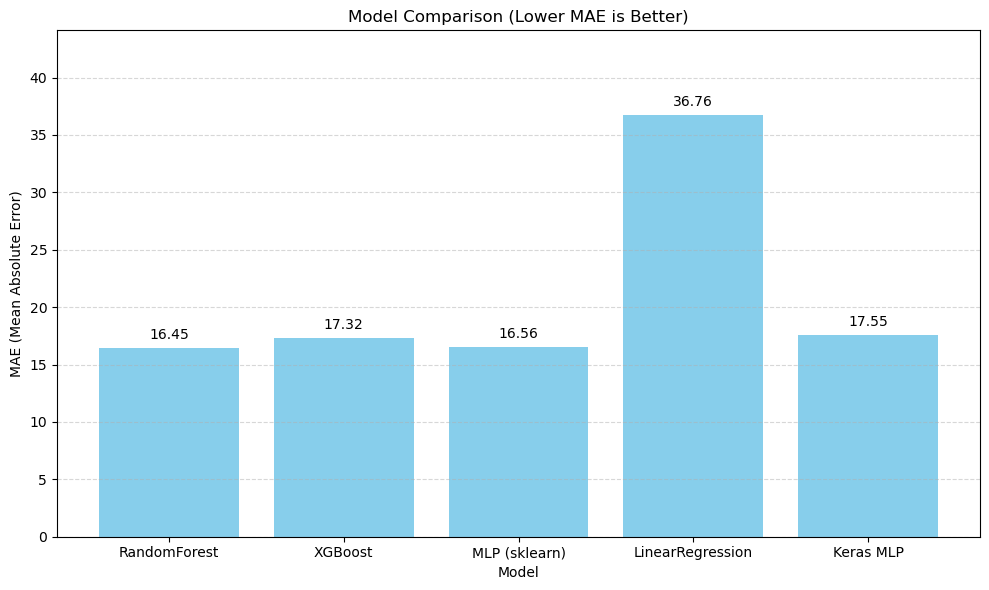

In [8]:
import matplotlib.pyplot as plt

# 📊 모델별 MAE 값 추출
model_names = list(results.keys())
mae_scores = [metrics['mae'] for metrics in results.values()]

# 🎨 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mae_scores, color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE (Mean Absolute Error)')
plt.title('Model Comparison (Lower MAE is Better)')
plt.ylim(0, max(mae_scores)*1.2)

# 막대 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## **각도 Degree -> Radian**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 🔹 데이터 로드
df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info.csv')

# 🔹 피처 엔지니어링
df['dx'] = df['x_target'] - df['x_pos']
df['dy'] = df['y_target'] - df['y_pos']
df['dz'] = df['z_target'] - df['z_pos']
df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)

# 🔹 각도 정리: degree → radian → sin/cos
for axis in ['x', 'y']:
    df[f'{axis}_rad'] = np.deg2rad(df[f'{axis}_angle'])
    df[f'{axis}_sin'] = np.sin(df[f'{axis}_rad'])
    df[f'{axis}_cos'] = np.cos(df[f'{axis}_rad'])
display(df.head())

# 🔹 입력(X), 출력(y)
X = df[['dx', 'dy', 'dz', 'distance']]
y = df[['x_sin', 'x_cos', 'y_sin', 'y_cos']]

# 🔹 데이터 분할 및 정규화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

,x_pos,y_pos,z_pos,x_angle,y_angle,x_target,y_target,z_target,dx,dy,dz,distance,x_rad,x_sin,x_cos,y_rad,y_sin,y_cos
0,0.00,7.98,42.23,334.40,10.00,96.57908,7.773508,151.22130,96.57908,-0.206492,108.99130,145.625083,5.836381,-0.432086,0.901833,0.174533,0.173648,0.984808
1,0.00,7.98,39.63,54.72,10.00,26.68355,7.741399,144.31480,26.68355,-0.238601,104.68480,108.032292,0.955044,0.816339,0.577573,0.174533,0.173648,0.984808
2,6.03,7.97,45.15,161.33,-4.12,13.32130,7.917756,18.49203,7.29130,-0.052244,-26.65797,27.637170,2.815740,0.320117,-0.947378,-0.071908,-0.071846,0.997416
3,74.04,7.97,129.11,45.33,-5.00,88.44806,7.904514,142.24230,14.40806,-0.065486,13.13230,19.494968,0.791158,0.711168,0.703022,-0.087266,-0.087156,0.996195
4,158.52,8.00,233.38,267.27,8.29,60.68079,7.784992,245.00810,-97.83921,-0.215008,11.62810,98.528016,4.664741,-0.998865,-0.047629,0.144688,0.144183,0.989551


In [ ]:
# 🔹 유틸 함수
def recover_angles(y_pred):
    x_sin, x_cos = y_pred[:, 0], y_pred[:, 1]
    y_sin, y_cos = y_pred[:, 2], y_pred[:, 3]
    x_angle = np.rad2deg(np.arctan2(x_sin, x_cos)) % 360
    y_angle = np.rad2deg(np.arctan2(y_sin, y_cos)) % 360
    return np.stack([x_angle, y_angle], axis=1)

def angle_mae(y_true_deg, y_pred_deg):
    error = np.abs((y_true_deg - y_pred_deg + 180) % 360 - 180)
    return np.mean(error), np.mean(error**2)

# 🔹 결과 저장
results = {}
predictions = {}

# 🔸 모델 리스트
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

# 🔸 훈련 및 평가 (sklearn 기반 모델)
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_deg = recover_angles(y_pred)
    y_true_deg = recover_angles(y_test.values)
    mae, mse = angle_mae(y_true_deg, y_pred_deg)
    results[name] = {'mae': mae, 'mse': mse}
    predictions[name] = y_pred_deg
    print(f'{name:15} | MAE = {mae:.4f}, MSE = {mse:.4f}')

# 🔸 Keras 모델
def build_keras_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(4)  # sin/cos for x and y
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

keras_model = build_keras_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

keras_model.fit(
    X_train_scaled, y_train.values,
    validation_split=0.2,
    epochs=200,
    batch_size=8,
    callbacks=[early_stop],
    verbose=0
)

y_pred_keras = keras_model.predict(X_test_scaled, verbose=0)
y_pred_keras_deg = recover_angles(y_pred_keras)
y_true_deg = recover_angles(y_test.values)
mae, mse = angle_mae(y_true_deg, y_pred_keras_deg)
results['Keras MLP'] = {'mae': mae, 'mse': mse}
predictions['Keras MLP'] = y_pred_keras_deg
print(f'Keras MLP        | MAE = {mae:.4f}, MSE = {mse:.4f}')

# 📈 성능 정리
print("\n📊 모델 성능 비교 (MAE 기준 정렬):")
sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
for name, metrics in sorted_results:
    print(f"{name:15} | MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f}")

LinearRegression | MAE = 9.7893, MSE = 410.5726
RandomForest    | MAE = 9.6710, MSE = 475.3341
XGBoost         | MAE = 10.1708, MSE = 549.8896
MLPRegressor    | MAE = 9.5134, MSE = 426.3618
KNN             | MAE = 9.7675, MSE = 478.7639
Keras MLP        | MAE = 10.0054, MSE = 432.3209

📊 모델 성능 비교 (MAE 기준 정렬):
MLPRegressor    | MAE: 9.5134 | MSE: 426.3618
RandomForest    | MAE: 9.6710 | MSE: 475.3341
KNN             | MAE: 9.7675 | MSE: 478.7639
LinearRegression | MAE: 9.7893 | MSE: 410.5726
Keras MLP       | MAE: 10.0054 | MSE: 432.3209
XGBoost         | MAE: 10.1708 | MSE: 549.8896


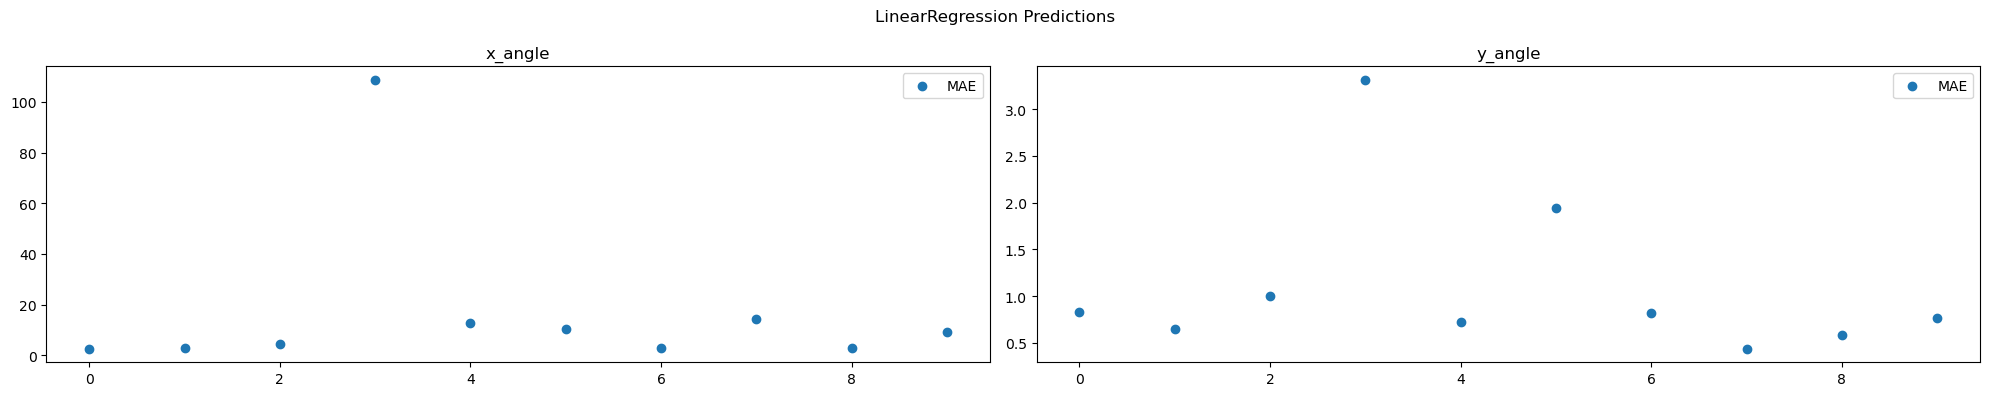

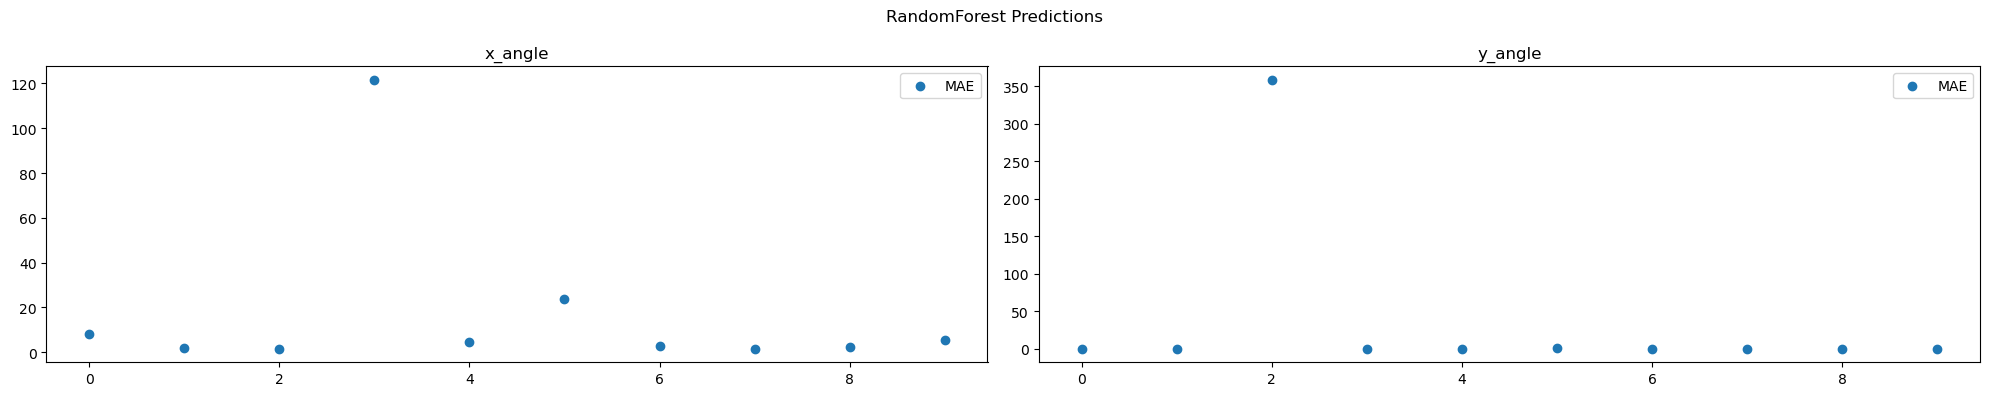

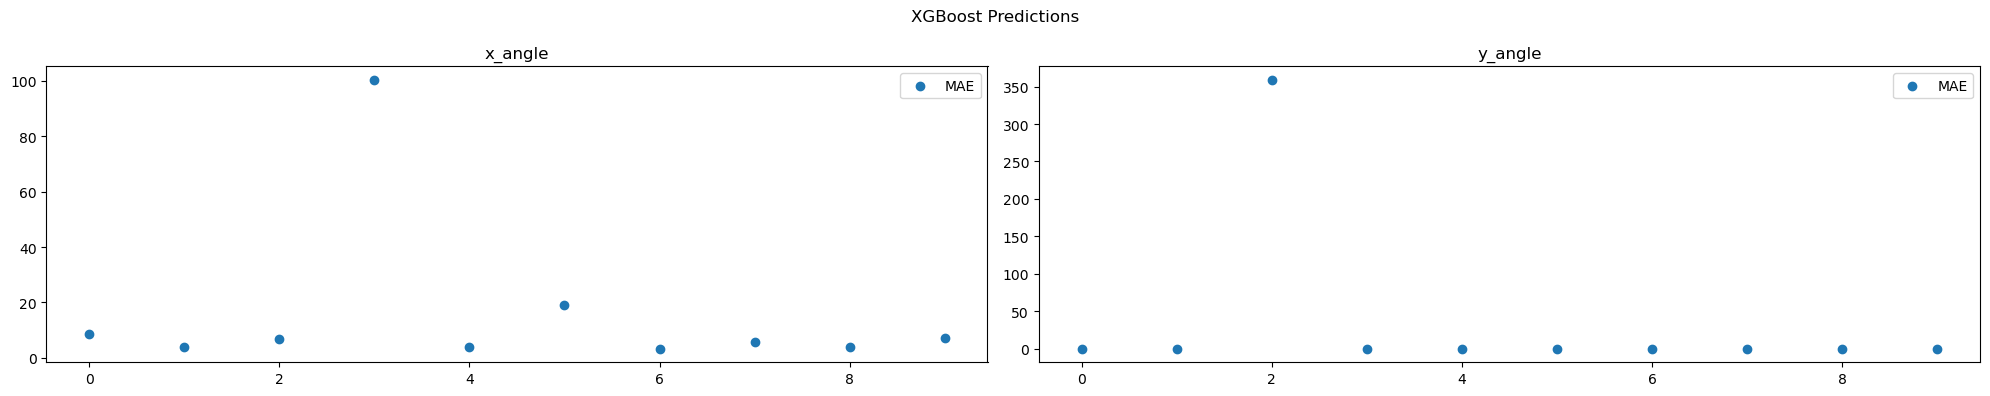

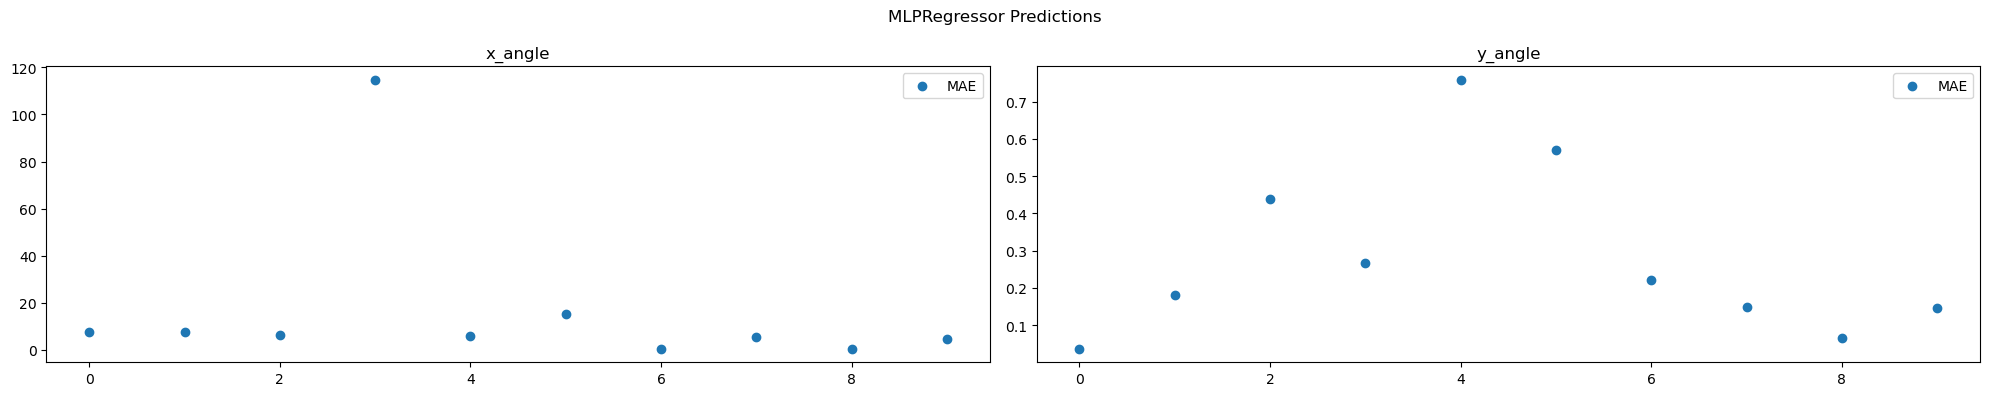

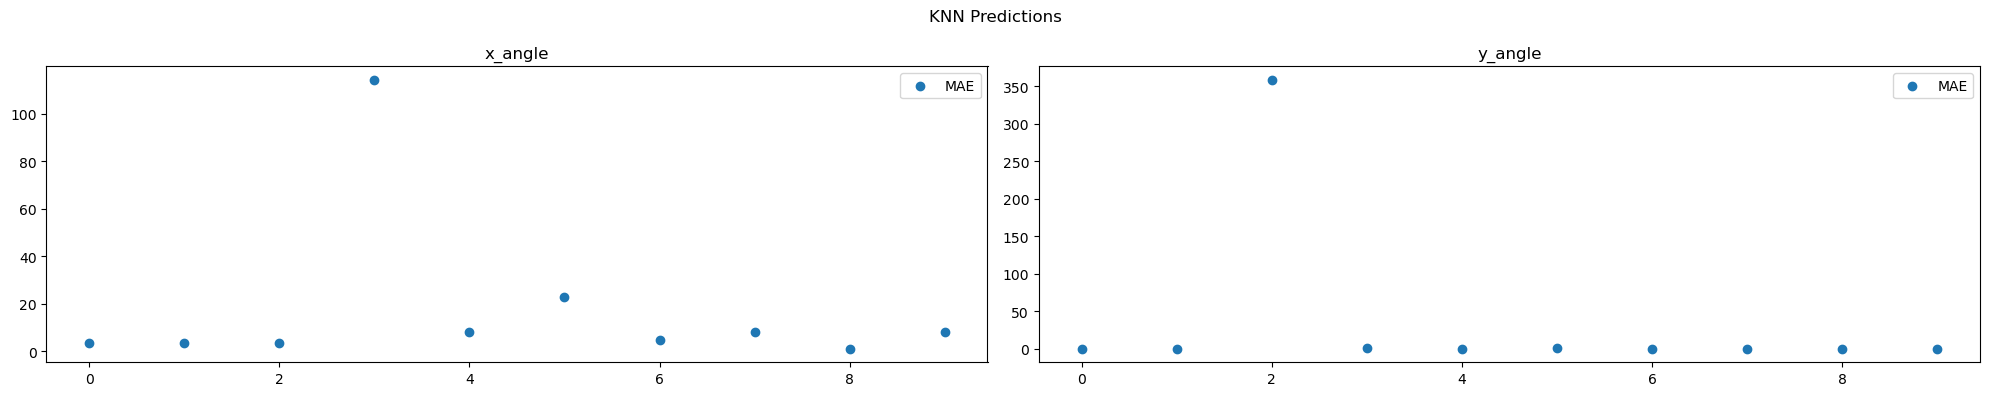

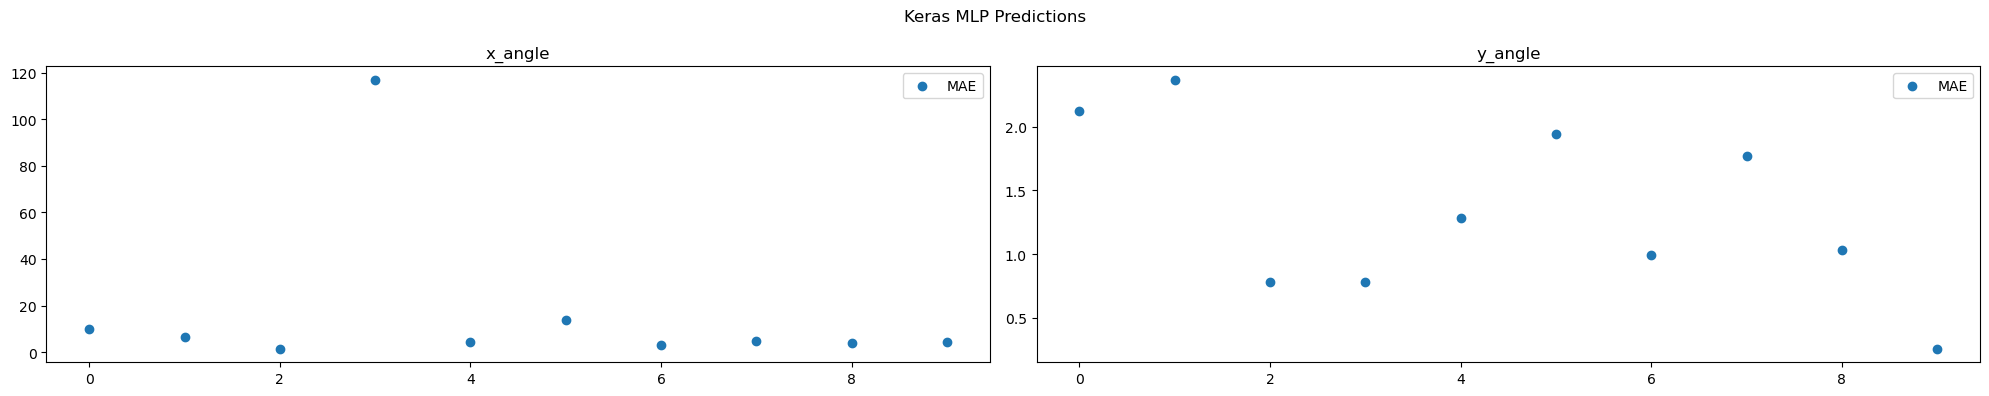

In [53]:
# 📉 시각화: 예측 vs 실제
n = 10
for name, y_pred in predictions.items():
    plt.figure(figsize=(20, 4))
    plt.suptitle(f'{name} Predictions')

    plt.subplot(1, 2, 1)
    plt.scatter(range(n), abs(y_true_deg[:n, 0] - y_pred[:n, 0]), label='MAE')
    plt.title('x_angle')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(range(n), abs(y_true_deg[:n, 1] - y_pred[:n, 1]), label='MAE')
    plt.title('y_angle')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [58]:
# 🔸 입력값 정의 0.0,7.99,183.9,182.15,10.0,-1.27202,10.99733,174.5425
input_data = [0.0,7.99,183.9,252.11, -1.27202,10.99733,174.5425]

dx = input_data[0] - input_data[3]
dy = input_data[1] - input_data[4]
dz = input_data[2] - input_data[5]
dist = (dx**2 + dy**2 + dz**2)**0.5

input_data = np.array([[dx, dy, dz, dist]])

# 🔸 스케일링 (X_train_scaled 기준 스케일러 사용)
input_scaled = scaler.transform(input_data)

# 🔸 예측
y_pred_raw = models['LinearRegression'].predict(input_scaled)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"예측된 각도 (deg): x_angle = {y_pred_deg[0, 0]:.2f}°, y_angle = {y_pred_deg[0, 1]:.2f}°")

input_data = [0.0,7.99,183.9,252.11, -1.27202,10.99733,174.5425]

dx = input_data[0] - input_data[3]
dy = input_data[1] - input_data[4]
dz = input_data[2] - input_data[5]
dist = (dx**2 + dy**2 + dz**2)**0.5

input_data = np.array([[dx, dy, dz, dist]])

# 🔸 스케일링 (X_train_scaled 기준 스케일러 사용)
input_scaled = scaler.transform(input_data)

# 🔸 예측
y_pred_raw = keras_model.predict(input_scaled)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"예측된 각도 (deg): x_angle = {y_pred_deg[0, 0]:.2f}°, y_angle = {y_pred_deg[0, 1]:.2f}°")

예측된 각도 (deg): x_angle = 296.88°, y_angle = 31.26°
1/1 [==============================] - 0s 23ms/step
예측된 각도 (deg): x_angle = 265.39°, y_angle = 18.45°


/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## **LinearRegression, Keras 모델 비교**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 🔹 데이터 로드
df = pd.read_csv('/root/jupyter_home/tank_project/ready/포탑제어 파트/Data/turret_info.csv')

# 🔹 피처 엔지니어링
df['dx'] = df['x_target'] - df['x_pos']
df['dy'] = df['y_target'] - df['y_pos']
df['dz'] = df['z_target'] - df['z_pos']
df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)

# 🔹 각도 정리: degree → radian → sin/cos
df[f'y_rad'] = np.deg2rad(df[f'y_angle'])
df[f'y_sin'] = np.sin(df[f'y_rad'])
df[f'y_cos'] = np.cos(df[f'y_rad'])
display(df.head())

# 🔹 입력(X), 출력(y)
X = df[['distance']]
y = df[['y_sin', 'y_cos']]

# 🔹 데이터 분할 및 정규화
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

,x_pos,y_pos,z_pos,x_angle,y_angle,x_target,y_target,z_target,dx,dy,dz,distance,y_rad,y_sin,y_cos
0,0.00,7.98,42.23,334.40,10.00,96.57908,7.773508,151.22130,96.57908,-0.206492,108.99130,145.625083,0.174533,0.173648,0.984808
1,0.00,7.98,39.63,54.72,10.00,26.68355,7.741399,144.31480,26.68355,-0.238601,104.68480,108.032292,0.174533,0.173648,0.984808
2,6.03,7.97,45.15,161.33,-4.12,13.32130,7.917756,18.49203,7.29130,-0.052244,-26.65797,27.637170,-0.071908,-0.071846,0.997416
3,74.04,7.97,129.11,45.33,-5.00,88.44806,7.904514,142.24230,14.40806,-0.065486,13.13230,19.494968,-0.087266,-0.087156,0.996195
4,158.52,8.00,233.38,267.27,8.29,60.68079,7.784992,245.00810,-97.83921,-0.215008,11.62810,98.528016,0.144688,0.144183,0.989551


In [63]:
# 🔹 유틸 함수
def recover_angles(y_pred):
    y_sin, y_cos = y_pred[:, 0], y_pred[:, 1]
    y_angle = np.rad2deg(np.arctan2(y_sin, y_cos)) % 360
    return np.stack([y_angle], axis=1)

def angle_mae(y_true_deg, y_pred_deg):
    error = np.abs((y_true_deg - y_pred_deg + 180) % 360 - 180)
    return np.mean(error), np.mean(error**2)

# 🔹 결과 저장
results = {}
predictions = {}

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred_deg = recover_angles(y_pred)
y_true_deg = recover_angles(y_test.values)
mae, mse = angle_mae(y_true_deg, y_pred_deg)
results['LinearRegression'] = {'mae': mae, 'mse': mse}
predictions['LinearRegression'] = y_pred_deg
print(f'LinearRegression: | MAE = {mae:.4f}, MSE = {mse:.4f}')

# 🔸 Keras 모델
def build_keras_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)  # sin/cos for y
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

keras_model = build_keras_model(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

keras_model.fit(
    X_train_scaled, y_train.values,
    validation_split=0.2,
    epochs=200,
    batch_size=8,
    callbacks=[early_stop],
    verbose=0
)

y_pred_keras = keras_model.predict(X_test_scaled, verbose=0)
y_pred_keras_deg = recover_angles(y_pred_keras)
y_true_deg = recover_angles(y_test.values)
mae, mse = angle_mae(y_true_deg, y_pred_keras_deg)
results['Keras MLP'] = {'mae': mae, 'mse': mse}
predictions['Keras MLP'] = y_pred_keras_deg
print(f'Keras MLP        | MAE = {mae:.4f}, MSE = {mse:.4f}')

# 📈 성능 정리
print("\n📊 모델 성능 비교 (MAE 기준 정렬):")
sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
for name, metrics in sorted_results:
    print(f"{name:15} | MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f}")

LinearRegression: | MAE = 1.5822, MSE = 4.7501
Keras MLP        | MAE = 0.9513, MSE = 2.0417

📊 모델 성능 비교 (MAE 기준 정렬):
Keras MLP       | MAE: 0.9513 | MSE: 2.0417
LinearRegression | MAE: 1.5822 | MSE: 4.7501


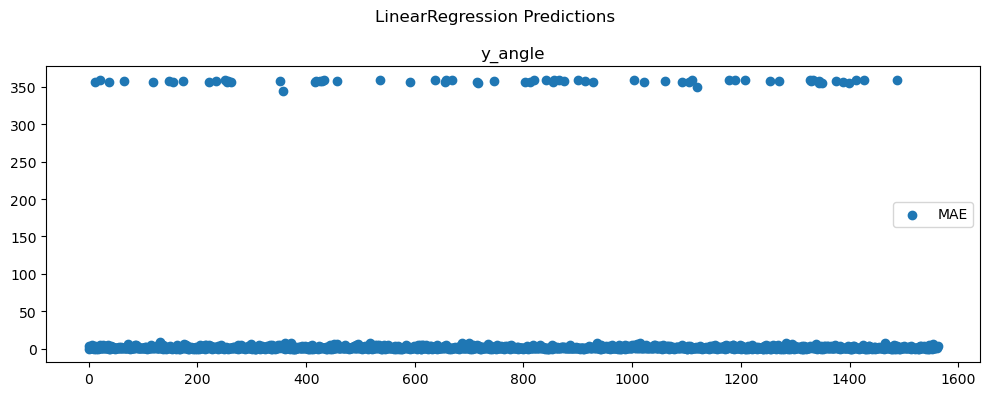

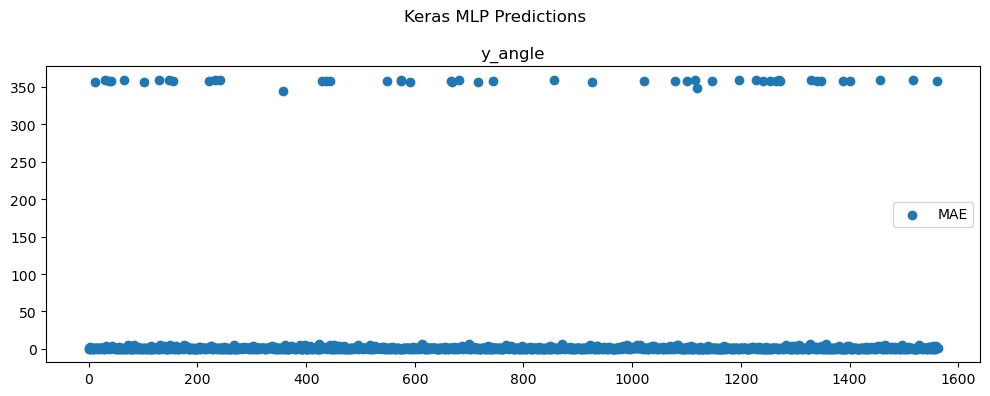

In [69]:
# 📉 시각화: 예측 vs 실제
for name, y_pred in predictions.items():
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'{name} Predictions')

    plt.scatter(range(len(y_pred)), abs(y_true_deg[:, 0] - y_pred[:, 0]), label='MAE')
    plt.title('y_angle')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# 🔸 입력값 정의 0.0,7.99,183.9,182.15,10.0,-1.27202,10.99733,174.5425
input_data = [0.0,7.99,183.9,252.11, -1.27202,10.99733,174.5425]

dx = input_data[0] - input_data[3]
dy = input_data[1] - input_data[4]
dz = input_data[2] - input_data[5]
dist = (dx**2 + dy**2 + dz**2)**0.5

input_data = np.array([[dist]])

# 🔸 스케일링 (X_train_scaled 기준 스케일러 사용)
input_scaled = scaler.transform(input_data)

# 🔸 예측
y_pred_raw = model.predict(input_scaled)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

input_data = [0.0,7.99,183.9,252.11, -1.27202,10.99733,174.5425]

dx = input_data[0] - input_data[3]
dy = input_data[1] - input_data[4]
dz = input_data[2] - input_data[5]
dist = (dx**2 + dy**2 + dz**2)**0.5

input_data = np.array([[dist]])

# 🔸 스케일링 (X_train_scaled 기준 스케일러 사용)
input_scaled = scaler.transform(input_data)

# 🔸 예측
y_pred_raw = keras_model.predict(input_scaled)

# 🔸 각도 복원
y_pred_deg = recover_angles(y_pred_raw)

print(f"예측된 각도 (deg): y_angle = {y_pred_deg[0, 0]:.2f}°")

예측된 각도 (deg): y_angle = 28.99°
1/1 [==============================] - 0s 27ms/step
예측된 각도 (deg): xy_angle = 10.51°


/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/root/anaconda3/envs/keras_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
